# API keys

## Purpose

In this notebook, we are going to set up the infotrmation we need to be able to access the various APIs we will use in these courses. 

We will do this in a flexible and general manner by storing relevant API keys as environemnat variables on your computer. This allows us to make easy use of API keys, without the need to expose them in our code.

For each API, you will need to register at the appropriate webpage.

## Requirements

You need to have a general idea of what an AOi is.

You should have familiarity with running cells in a notebook.

### What is an API?

### What is an API key?

# api.nasa.gov

One AP we will make extensive use of is the NASA data API.

You should register for this at [https://api.nasa.gov/](https://api.nasa.gov/).

* Go to the `Generate API Key` tab on this page, fill out the form and signup.
  You will receive a response telling you your API key which will look something like:

        lfXatLwwsS3BG133GsHtQp6BbVqMqMGgIepdJ7ty

    Note, the key here is *not* a valid key, simply an example of the format.

* In the cell below, replace this example key with 

In [1]:
%%bash
NASA_API_KEY=lcX6tLxwsS3BGx36GwHtQp6BbVqMqMGfIepdJ9tZ
echo "NASA_API_KEY=${NASA_API_KEY}" >> ~/.bashrc

In [5]:
import os
NASA_API_KEY=os.getenv('NASA_API_KEY')
print(NASA_API_KEY)

lcX6tLxwsS3BGx36GwHtQp6BbVqMqMGfIepdJ9tZ


In [8]:
import sys
import json
import os
from getpass import getpass
from pathlib import Path
from jupyter_client import kernelspec
import requests
from PIL import Image, ImageOps

class getAPIkey():
    '''
    class to return API key that may be stored in various places

    Method to get API key if it exists
    or prompt for it otherwise.
    
    Checklist of places to look:
    - os.getenv(keyname)
    - ~/.bashrc
      as environment variable
      of form: 
          NASA_API_KEY=1234567ghts
      The interpretation is configurable to allow for other shells
      via the parameters
                 bashenv={
                     'name' :'.bashrc',
                     'split':'=',
                     'len'  : 2,
                     'value': 1,
                     'key'  : 0,
                 }
    - jupyter kernel file
        f'{sys.prefix}/share/jupyter/kernels/{database}/kernel.json'
        
    Result is stored in:
    - jupyter kernel file
        f'{sys.prefix}/share/jupyter/kernels/{database}/kernel.json'
    '''
    def __init__(self,keyname='NASA_API_KEY',
                 force=False,
                 verbose=False,
                 bashenv={
                     'name' :'.bashrc',
                     'split':'=',
                     'len'  : 2,
                     'value': 1,
                     'key'  : 0
                 },
                 store=True,
                 backup='python3',
                 database='uclgeog'):
        self.keyname = keyname
        self.force = force
        self.verbose = verbose
        self.bashenv = bashenv
        self.store = store
        
        # these are notebook kernels
        # backup would normally be python3
        # we will copy from backup if 
        # databsse doesnt exist
        self.database = database
        self.backup = backup
        
        # force the user to enter 
        if self.force:
            self.keyvalue = self.give_it_to_me()
        
        # get it from env if its there
        self.keyvalue = None
        
    def look_in_getenv(self,keyname=None):
        keyname = keyname or self.keyname
        keyvalue = os.getenv(keyname)
        return keyvalue
        
    def look_in_bashrc(self,keyname=None,bashenv=None):
        bashenv = bashenv or self.bashenv
        keyname = keyname or self.keyname
        keyvalue = None
        try:
            kernel = Path.home() / bashenv['name']
            with(open(kernel,'r')) as f:
                for line in f.readlines():
                    # remove export if its there
                    if line.rstrip().split()[0] == 'export':
                        line = line.replace('export','').lstrip()
                    s = line.rstrip().split(bashenv['split'])
                    if (s[bashenv['key']] == keyname) and len(s) == bashenv['len']:
                        keyvalue = s[bashenv['value']]
        except:
            pass
        return keyvalue

    def look_in_notebook_specs(self,keyname=None,speclist=None):
        '''
        find keyname in kernelspec
        and return the first we find 
        
        store (specitem,keyname,keyvalue) in self.specitem
        '''
        keyname = keyname or self.keyname
        keyvalue = None
        speclist = speclist or kernelspec.find_kernel_specs().keys()
        speclist = list(speclist)
        # look over list
        try:
            for specitem in speclist:
                try:
                    spec = kernelspec.get_kernel_spec(specitem)
                    env = spec.env
                    if keyname in env:
                        keyvalue = spec[keyname]
                        self.specitem = (specitem,keyname,keyvalue)
                        return keyvalue
                except:
                    pass
        except:
            pass
        return keyvalue
    
    def give_it_to_me(self,keyname=None):
        '''
        interactive request for API key from user
        '''
        keyname = keyname or self.keyname
        keyvalue = getpass(prompt=f'Enter {keyname}:')
        return keyvalue
    
    def find(self,keyname=None):
        keyname = keyname or self.keyname
        keyvalue = self.keyvalue or \
           self.look_in_getenv(keyname=keyname) or \
           self.look_in_bashrc(keyname=keyname) or\
           self.look_in_notebook_specs(keyname=keyname,speclist=self.database) or\
           self.look_in_notebook_specs(keyname=keyname) or \
           self.give_it_to_me()
        try:
            os.environ[keyname]=keyvalue
        except:
            pass
        return keyvalue
    
    def make_icons(self,spec):
        '''
        Use UCL icon file to make 64 x 64 and 32 x 32 logo images
        and store in resource dir
        '''
        # put logo file in resource dir
        ucllogo = Path(spec.resource_dir + '/ucl_logo.png')
        logo3232 = Path(spec.resource_dir + '/logo-32x32.png')
        logo6464 = Path(spec.resource_dir + '/logo-64x64.png')
        url = 'https://raw.githubusercontent.com/UCL-EO/uclgeog/master/images/ucl_logo.png'
        try:
            r = requests.get(url, allow_redirects=True)
            open(ucllogo, 'wb').write(r.content)
            # now make logo
            image = Image.open(ucllogo)
            aspect_ratio = image.size[0]/image.size[1]
            big = int(aspect_ratio * 64)
            image = image.resize((big,64),Image.ANTIALIAS)
            new_im = Image.new('RGB',(big,big),(255, 255, 255)) # White
            new_im.paste(image, image.getbbox())  # Not cent
            new_im.resize((64,64),Image.ANTIALIAS).save(logo6464)
            new_im.resize((32,32),Image.ANTIALIAS).save(logo3232)
            return new_im
        except:
            return None

    def write_bash(self,keyname=None,bashenv=None):
        '''
        Dont change the bashenv at the moment
        as its only partially implemented
        '''
        verbose = self.verbose
        bashenv = bashenv or self.bashenv
        keyname = keyname or self.keyname
        keyvalue = self.find()
        try:
            kernel = Path.home() / bashenv['name']
            # write to the end of this
            with(open(kernel,'a+')) as f:
                # dont take notice of bashenv at the moment
                line = f'export {keyname}={keyvalue}\n'
                f.write(line)
        except:
            pass
        return kernel
    
    def write_notebook(self,specname=None,backup=None,keyname=None):
        '''
        write keyvalue into database notebook kernel file
        '''
        verbose = self.verbose
        # see https://jupyter-client.readthedocs.io/en/latest/kernels.html
        specname = specname or self.database
        backup = backup or self.backup
        keyname = keyname or self.keyname
        try:
            # exists
            spec = kernelspec.get_kernel_spec(specname)
        except:
            # doesnt exist
            spec = kernelspec.get_kernel_spec(backup)
            kernel_file = kernelspec.find_kernel_specs()[backup]
            # create specname
            # try as user then not
            try:
                kernelspec.install_kernel_spec(kernel_file,
                kernel_name=specname, user=False,replace=True)
            except:
                kernelspec.install_kernel_spec(kernel_file,
                                               kernel_name=specname, 
                                               user=True,replace=True)
        try:
            spec = kernelspec.get_kernel_spec(specname)
            # now load specname
            # make a name derived from specname
            spec.display_name = ' '.join([i.capitalize() for i in specname.split('_')])
            # make sure language is python
            spec.language='python'
            # add env variable if we can
            if spec.has_trait('env'):
                spec.env[keyname] = keyvalue
            else:
                # work out how to add env trait at some point
                pass

            # Serializing json 
            json_object  = spec.to_json()

            # write this out
            kernel = Path(spec.resource_dir + '/kernel.json')
            kernel.parent.mkdir(parents=True, exist_ok=True)
            with open(kernel, 'w') as f:
                if verbose:
                    print(f'jupyter kernel written to {kernel}')
                f.write(json_object) 

            self.make_icons(spec)
            # load again for luck
            spec = kernelspec.get_kernel_spec(specname)
            return spec
        except:
            return None

    def set(self):
        '''
        write the API key to notebook and bashrc
        '''
        spec=api.write_notebook()
        bashrc=api.write_bash()


In [11]:
'''
Use of api grabber

force = True to force input from user
'''
keyname='NASA_API_KEY'
api = getAPIkey(keyname,force=False)
keyvalue = api.find()
spec=api.write_notebook()
bashrc=api.write_bash()
print(keyname,keyvalue)

NASA_API_KEY lcX6tLxwsS3BGx36GwHtQp6BbVqMqMGfIepdJ9tZ


In [12]:
print(bashrc)
#help(os.putenv)

/Users/plewis/.bashrc


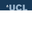

In [257]:

def make_icons(self,spec):
    '''
    Use UCL icon file to make 64 x 64 and 32 x 32 logo images
    and store in resource dir
    '''
    # put logo file in resource dir
    ucllogo = Path(spec.resource_dir + '/ucl_logo.png')
    logo3232 = Path(spec.resource_dir + '/logo-32x32.png')
    logo6464 = Path(spec.resource_dir + '/logo-64x64.png')
    url = 'https://raw.githubusercontent.com/UCL-EO/uclgeog/master/images/ucl_logo.png'
    try:
        r = requests.get(url, allow_redirects=True)
        open(ucllogo, 'wb').write(r.content)
        # now make logo
        image = Image.open(ucllogo)
        aspect_ratio = image.size[0]/image.size[1]
        big = int(aspect_ratio * 64)
        image = image.resize((big,64),Image.ANTIALIAS)
        new_im = Image.new('RGB',(big,big),(255, 255, 255)) # White
        new_im.paste(image, image.getbbox())  # Not cent
        new_im.resize((64,64),Image.ANTIALIAS).save(logo6464)
        new_im.resize((32,32),Image.ANTIALIAS).save(logo3232)
        return new_im
    except:
        return None


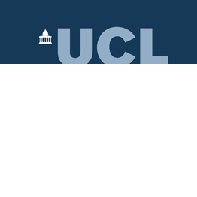

In [253]:
image = Image.open(ucllogo)
aspect_ratio = image.size[0]/image.size[1]
big = int(aspect_ratio * 64)
image = image.resize((big,64),Image.ANTIALIAS)
padding = (big,big)
new_im = Image.new('RGB',
                 (big,big),   # A4 at 72dpi
                 (255, 255, 255))  # White
new_im.paste(image, image.getbbox())  # Not cent


In [246]:
help(ImageOps.expand)

Help on function expand in module PIL.ImageOps:

expand(image, border=0, fill=0)
    Add border to the image
    
    :param image: The image to expand.
    :param border: Border width, in pixels.
    :param fill: Pixel fill value (a color value).  Default is 0 (black).
    :return: An image.



In [209]:
!jupyter kernelspec list

Available kernels:
  c                   /Users/plewis/Library/Jupyter/kernels/c
  python3             /Users/plewis/opt/anaconda3/envs/uclgeog/share/jupyter/kernels/python3
  uclgeog    /usr/local/share/jupyter/kernels/uclgeog


In [206]:
spec.to_dict()

{'argv': ['/Users/plewis/opt/anaconda3/envs/uclgeog/bin/python',
  '-m',
  'ipykernel_launcher',
  '-f',
  '{connection_file}'],
 'env': {'NASA_API_KEY': 'lcX6tLxwsS3BGx36GwHtQp6BbVqMqMGfIepdJ9tZ'},
 'display_name': 'Uclgeog Msc Core',
 'language': 'python',
 'interrupt_mode': 'signal',
 'metadata': {}}

In [173]:
Path(spec.resource_dir).parent.mkdir(parents=True, exist_ok=True)
jspec = spec.to_json()
with open(kernel, 'w') as f:
    jspec.dump(setup,f)

'{"argv": ["/Users/plewis/opt/anaconda3/envs/uclgeog/bin/python", "-m", "ipykernel_launcher", "-f", "{connection_file}"], "env": {"NASA_API_KEY": "lcX6tLxwsS3BGx36GwHtQp6BbVqMqMGfIepdJ9tZ"}, "display_name": "Uclgeog Msc Core", "language": "python", "interrupt_mode": "signal", "metadata": {}}'

In [143]:
kernelspec.find_kernel_specs()['python3']

'/Users/plewis/opt/anaconda3/envs/uclgeog/share/jupyter/kernels/python3'

In [43]:
import sys
import json
import os
from getpass import getpass
from pathlib import Path
from jupyter_client import kernelspec

def get_apikey(keyname='NASA_API_KEY',
                 force=False,
                 verbose=False,
                 bashenv={
                     'name' :'.bashrc',
                     'split':'=',
                     'len'  : 2,
                     'value': 1,
                     'key'  : 0
                 },
                 store=True,
                 database='uclgeog'):
    '''
    Method to get API key if it exists
    or prompt for it otherwise.
    
    Checklist of places to look:
    - os.getenv(keyname)
    - ~/.bashrc
      as environment variable
      of form: 
          NASA_API_KEY=1234567ghts
      The interpretation is configurable to allow for other shells
      via the parameters
                 bashenv={
                     'name' :'.bashrc',
                     'split':'=',
                     'len'  : 2,
                     'value': 1,
                     'key'  : 0,
                 }
    - jupyter kernel file
        f'{sys.prefix}/share/jupyter/kernels/{database}/kernel.json'
        
    Result is stored in:
    - jupyter kernel file
        f'{sys.prefix}/share/jupyter/kernels/{database}/kernel.json'
    '''
    # try to getenv the key
    keyvalue = None
    if keyvalue is None:
        try:
            keyvalue=os.getenv(keyname)     
        except:
            pass

    # read ${HOME}/.bashrc
    # take the last entry
    if keyvalue is None:
        try:
            kernel = Path.home() / bashenv['name']
            with(open(kernel,'r')) as f:
                for line in f.readlines()
                    s = line.rstrip().split(bashenv['split'])
                    if (s[bashenv['key']] == keyname) and len(s) == bashenv['len']:
                        keyvalue = s[bashenv['value']]
        except:
            pass
    
    if keyvalue is None:
        # next, look in 
        # check in database json file
        # see 
        # https://jupyter-client.readthedocs.io/en/stable/kernels.html#kernel-specs
        try:
            kernel = kernelspec.get_kernel_spec(database).resource_dir
            # try this database json 
            with open(kernel, 'r') as f:
                setup = json.load(f)
            # init
            if 'env' not in setup:
                setup['env'] = {}
            envdict = setup['env']
            if keyname in envdict:
                keyvalue = envdict[keyname]
    except:
            pass
        
    if store:
        try:
            # load info from database
            try:
                kernel = f'{sys.prefix}/share/jupyter/kernels/{database}/kernel.json'
                with open(kernel, 'r') as f:
                    setup = json.load(f)
            # load from python3 kernel
            except:
                kernel = f'{sys.prefix}/share/jupyter/kernels/python3/kernel.json'
                with open(kernel, 'r') as f:
                    setup = json.load(f)
            

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [73]:
print(database)

cc


In [218]:
def 


2802